In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from datetime import datetime

print("TF version = ", tf.VERSION)
print("Keras version = ",keras.__version__)
print("Keras backend = ", keras.backend.backend())
print("Default float type = ", keras.backend.floatx())
print("Image data structure = ", keras.backend.image_data_format())

def get_config_proto():
    config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    config.gpu_options.allow_growth = True
    return config

def set_session_config(config):
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
    
set_session_config(get_config_proto())

TF version =  1.11.0
Keras version =  2.1.6-tf
Keras backend =  tensorflow
Default float type =  float32
Image data structure =  channels_last


In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Turn ints to floats and Normalize values to <0,1>
x_train = x_train/255.0
x_test = x_test/255.0

In [3]:
print('x_train.shape', x_train.shape)
print('y_train.shape={} y_train[:5]={}'.format(y_train.shape, y_train[:5]))

x_train.shape (60000, 28, 28)
y_train.shape=(60000,) y_train[:5]=[5 0 4 1 9]


### Build encoder and decoder

Using variable scopes leads to nicer grouping in Tensorboard graph, but is unnecessary if you name Models.

In [4]:
LATENT_DIM = 16
IMG_SHAPE = (28, 28)
NOISE_RATIO = 0.1

def build_encoder():
    #with tf.variable_scope('encoder'):
    input_img = layers.Input(shape=IMG_SHAPE, name='encoder_input')
    noisy_img = layers.GaussianNoise(stddev=NOISE_RATIO, name='noisy_input')(input_img)
    flattened = layers.Flatten()(noisy_img)
    fc1 = layers.Dense(LATENT_DIM*4, activation=keras.activations.relu, name='fc_1')(flattened)
    fc2 = layers.Dense(LATENT_DIM*2, activation=keras.activations.relu, name='fc_2')(fc1)
    latent_repr = layers.Dense(LATENT_DIM, activation=keras.activations.relu, name='latent_repr')(fc2)
    return Model(input_img, latent_repr, name='encoder')

def build_decoder():
    #with tf.variable_scope('decoder'):
    latent_repr = layers.Input(shape=(LATENT_DIM, ), name='latent_repr_input')
    x = layers.Dense(LATENT_DIM*2, activation=keras.activations.relu, name='fc_1')(latent_repr)
    x = layers.Dense(LATENT_DIM*4, activation=keras.activations.relu, name='fc_2')(x)
    x = layers.Dense(np.prod(IMG_SHAPE), activation=keras.activations.relu, name='fc_3')(x)
    output_img = layers.Reshape(IMG_SHAPE)(x)
    return Model(latent_repr, output_img, name='decoder')

### Custom metrics and callback

 - Metrics are calculated and passed to callbacks as `logs` dictionary
 - Metrics not included in `stateful_metrics` will be averaged at epoch end by `BaseLogger`
 - name of the metric method = `avg_latent_repr` = new metric name
 - if you want to evaluate tensors during training, you must pass them as metrics!
   - metrics must return only a single number
   - tensorboard callback will automatically plot all the metrics passed to model.compile()
 - known numbers as e.g. LR in a custom LR schedule function can be plotted by TensorBoard callback by adding it to logs in **any** callback
 - TensorBoard callback will plot averages of metrics over the `update_freq` = if update_freq=50, it will plot a number each 50 batches and the number will be an average over these 50 batches from `on_batch_end` `logs`
 - `on_batch_end` logs are different from `on_epoch_end` logs - they will be plotted in different plots by TensorBoard Callback

In [5]:
encoder = build_encoder()
decoder = build_decoder()

input_img = layers.Input(shape=IMG_SHAPE, name='input_img')
latent_repr = encoder(input_img)
output_img = decoder(latent_repr)

autoencoder = Model(input_img, output_img, name='autoencoder')

LOG_DIR = './tf_logs/' + datetime.now().strftime("%Y%m%d-%H%M%S")
#file_writer = tf.summary.FileWriter(LOG_DIR + "/metrics")

def avg_weight_metric():
    def avg_latent_repr(y_true, y_pred):
        return tf.reduce_mean(latent_repr)
        # This will throw: You must feed a value for placeholder tensor 'encoder_input' with dtype float and shape [?,28,28]
        #return tf.reduce_mean(autoencoder.get_layer('encoder').get_layer('latent_repr').output)
    return avg_latent_repr

class Custom_Callback(keras.callbacks.Callback):    
    def on_train_begin(self, logs={}):
        self._data = {'custom_metric':[]}
        self.global_step = 0
        
    def on_batch_end(self, batch, logs={}):
        self.global_step += 1
        # batch logs are different from epoch logs - they will be plotted in different plots by TensorBoard Callback
        logs['custom_metric'] = np.float32(self.global_step * 0.5) # just an example of a known number
        self._data['custom_metric'].append(logs['custom_metric'])

    def on_epoch_end(self, epoch, logs={}):
        # epoch indexed from 0
        # logs = dict of metrics and their values = will be in History object.
        
        # requires feeding the data
        # logs['custom_metric'] = keras.backend.eval(tf.reduce_mean(latent_repr))
        
        print('callback epoch:', epoch)
        print('callback logs:', logs)
        # this will plot global number of batches through epochs to plot: epoch_custom_metric
        logs['custom_metric'] = np.float32(self.global_step) # just an example of a known number

    def get_data(self):
        return self._data
    
class CustomTBCallback(keras.callbacks.TensorBoard):
    # just adding update_freq - its already done in TF 1.13+
    def __init__(self, update_freq='epoch', **kw):
        super(CustomTBCallback, self).__init__(**kw)
        if update_freq == 'batch':
            self.update_freq = 1
        else:
            self.update_freq = update_freq
    
    def on_batch_end(self, batch, logs=None):
        if self.update_freq != 'epoch' and batch % self.update_freq == 0:
            super(CustomTBCallback, self).on_batch_end(batch, logs)
            #print('Updated TensorBoard on batch ', batch)
        

autoencoder.compile(loss=['mse'], metrics=['acc', avg_weight_metric()], optimizer=keras.optimizers.Adam(0.002))

In [6]:
latent_repr

<tf.Tensor 'encoder/latent_repr/Relu:0' shape=(?, 16) dtype=float32>

In [7]:
autoencoder.get_layer('encoder').get_layer('latent_repr').output

<tf.Tensor 'latent_repr/Relu:0' shape=(?, 16) dtype=float32>

In [8]:
encoder.get_layer('latent_repr').output

<tf.Tensor 'latent_repr/Relu:0' shape=(?, 16) dtype=float32>

In [9]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 16)                52848     
_________________________________________________________________
decoder (Model)              (None, 28, 28)            53616     
Total params: 106,464
Trainable params: 106,464
Non-trainable params: 0
_________________________________________________________________


In [10]:
TB_callback = CustomTBCallback(log_dir=LOG_DIR, write_graph=True, update_freq=50)
metrics_cb = Custom_Callback()

history = autoencoder.fit(x_train, x_train,
              batch_size=128,
              epochs=10,
              verbose=2,
              validation_data=(x_test, x_test),
              callbacks=[metrics_cb, TB_callback]
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
callback epoch: 0
callback logs: {'val_loss': 0.030117464116215707, 'val_acc': 0.4560607139110565, 'val_avg_latent_repr': 2.6187257667541504, 'loss': 0.0409499473631382, 'acc': 0.39326369064648947, 'avg_latent_repr': 1.816442335510254}
 - 4s - loss: 0.0409 - acc: 0.3933 - avg_latent_repr: 1.8164 - val_loss: 0.0301 - val_acc: 0.4561 - val_avg_latent_repr: 2.6187
Epoch 2/10
callback epoch: 1
callback logs: {'val_loss': 0.026892438167333603, 'val_acc': 0.4721642864704132, 'val_avg_latent_repr': 2.9918492515563964, 'loss': 0.028858626795808473, 'acc': 0.4682767851670583, 'avg_latent_repr': 2.809181225967407}
 - 4s - loss: 0.0289 - acc: 0.4683 - avg_latent_repr: 2.8092 - val_loss: 0.0269 - val_acc: 0.4722 - val_avg_latent_repr: 2.9918
Epoch 3/10
callback epoch: 2
callback logs: {'val_loss': 0.026131403881311417, 'val_acc': 0.4841714301109314, 'val_avg_latent_repr': 3.06854147567749, 'loss': 0.027045044912894566, 'acc': 0.480328571

In [11]:
# These are the epoch logs only - the metrics passed to model.compile() are calculated each batch and then
# averaged to get the epoch value stored in history
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_avg_latent_repr', 'loss', 'acc', 'avg_latent_repr', 'custom_metric'])

In [14]:
metrics_cb.get_data()['custom_metric'][:15]

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]

In [15]:
num_pred = 16
predicted_imgs = autoencoder.predict(x_test[:num_pred]) 

In [17]:
# equivalent to predicted_imgs = autoencoder.predict(x_test[:num_pred]) 
latent_reprs = encoder.predict(x_test[:num_pred])
predicted_imgs2 = decoder.predict(latent_reprs)

assert np.allclose(predicted_imgs, predicted_imgs2)

In [18]:
latent_reprs[0]

array([0.       , 0.       , 3.5976708, 4.61082  , 3.9677374, 7.2461915,
       0.       , 3.0952578, 2.174544 , 1.486566 , 2.800192 , 0.       ,
       2.745033 , 2.1467686, 2.8717568, 3.4889765], dtype=float32)

Original Images


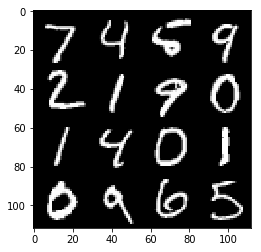

Noisy input image


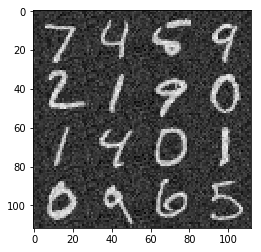

Reconstructed Images


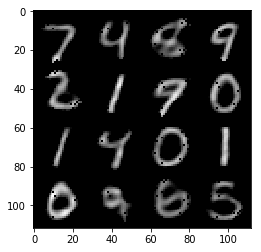

In [19]:
n = int(np.ceil(np.sqrt(num_pred)))
canvas_orig = []
canvas_recon = []
canvas_noisy = []
for i in range(n):
    # Display noisy input images
    canvas_noisy.append(np.concatenate((x_test[i*4:(i+1)*4] + np.random.normal(scale=NOISE_RATIO, size=IMG_SHAPE))))
    # Display original images
    canvas_orig.append(np.concatenate((x_test[i*4:(i+1)*4])))
    # Display reconstructed images
    canvas_recon.append(np.concatenate((predicted_imgs[i*4:(i+1)*4])))

print("Original Images")
plt.figure(figsize=(n, n))
plt.imshow(np.concatenate(canvas_orig, axis=1), origin="upper", cmap="gray")
plt.show()
    
print("Noisy input image")
plt.figure(figsize=(n, n))
plt.imshow(np.concatenate(canvas_noisy, axis=1), origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(np.concatenate(canvas_recon, axis=1), origin="upper", cmap="gray")
plt.show()